# Enriquecimiento de predicciones ARIMA con datos reales de ventas

Este notebook cruza las predicciones generadas por un modelo ARIMA con los datos históricos del archivo `sell-in.txt`, específicamente para el período `201912`.

El objetivo es comparar o enriquecer la predicción con la venta real (`tn`) observada ese mes.


In [1]:

import pandas as pd


## Carga de archivos

In [2]:

# Definir rutas
PATH_FORECAST = "C:\\Developer\\Laboratorio_III\\data\\forecast_product_phase1.csv"
PATH_SELLIN = "C:\\Developer\\Laboratorio_III\\data\\sell-in.txt"

# Cargar predicciones
df_pred = pd.read_csv(PATH_FORECAST)

# Cargar ventas
df_sellin = pd.read_csv(PATH_SELLIN, sep="\t")
df_sellin['periodo'] = df_sellin['periodo'].astype(str)


## Cruce de predicción con datos reales del período 201912

In [3]:

# Filtrar ventas de diciembre 2019
df_dic = df_sellin[df_sellin['periodo'] == '201912']

# Agregar ventas por producto
ventas_diciembre = df_dic.groupby('product_id')['tn'].sum().reset_index()
ventas_diciembre = ventas_diciembre.rename(columns={'tn': 'tn_real'})

# Cruce con predicciones
df_enriquecido = df_pred.merge(ventas_diciembre, on='product_id', how='left')


## Guardado del archivo enriquecido

In [4]:

df_enriquecido.to_csv("forecast_product_phase1_con_real.csv", index=False)
print("Archivo generado: forecast_product_phase1_con_real.csv")


Archivo generado: forecast_product_phase1_con_real.csv


## Visualización interactiva: Predicción vs. Real

Generamos un gráfico de dispersión (`scatter plot`) donde:

- Eje X: predicción del modelo (`tn`)
- Eje Y: venta real observada (`tn_real`)

Además, incorporamos un filtro interactivo para seleccionar uno o varios `product_id` y analizar sus resultados individualmente.


In [5]:

import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Widget interactivo de selección de productos
productos_unicos = df_enriquecido['product_id'].unique()
selector = widgets.SelectMultiple(
    options=sorted(productos_unicos),
    value=sorted(productos_unicos)[:10],
    description='Productos',
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
)

# Función de visualización
def plot_scatter(productos):
    datos = df_enriquecido[df_enriquecido['product_id'].isin(productos)]
    fig = px.scatter(
        datos,
        x="tn", y="tn_real",
        hover_name="product_id",
        title="Predicción vs. Real (por producto)",
        labels={"tn": "Predicción (tn)", "tn_real": "Real (tn)"}
    )
    fig.add_shape(
        type='line',
        x0=0, y0=0, x1=datos['tn'].max(), y1=datos['tn'].max(),
        line=dict(color='gray', dash='dash')
    )
    fig.show()

# Mostrar selector + gráfico
widgets.interact(plot_scatter, productos=selector);


interactive(children=(SelectMultiple(description='Productos', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), layout=Lay…

## Scatter global en escala logarítmica

Este gráfico muestra todas las predicciones vs. sus valores reales para el período `201912`, sin distinguir por `product_id`, y aplicando escala logarítmica en ambos ejes.

Sirve para observar la alineación general del modelo (cuán cerca están los puntos de la diagonal perfecta).


In [6]:

import plotly.express as px

# Filtrar filas sin valores nulos
df_plot = df_enriquecido.dropna(subset=['tn', 'tn_real'])
df_plot = df_plot[(df_plot['tn'] > 0) & (df_plot['tn_real'] > 0)]

fig = px.scatter(
    df_plot,
    x='tn', y='tn_real',
    log_x=True, log_y=True,
    title='Predicción vs. Real (escala logarítmica)',
    labels={'tn': 'Predicción (tn)', 'tn_real': 'Real (tn)'},
    height=500
)

# Línea de referencia ideal (y = x)
max_val = max(df_plot['tn'].max(), df_plot['tn_real'].max())
fig.add_shape(
    type='line',
    x0=1e-2, y0=1e-2,
    x1=max_val, y1=max_val,
    line=dict(color='gray', dash='dash')
)

fig.show()


## Desvío porcentual por producto (ordenado)

A continuación visualizamos el error porcentual relativo de cada producto:

\[
\text{Error \%} = \frac{|\text{Predicción} - \text{Real}|}{\text{Real}} \times 100
\]

Se ordenan los productos de mayor a menor desvío, para identificar cuáles presentan mayores discrepancias entre el modelo y la realidad.


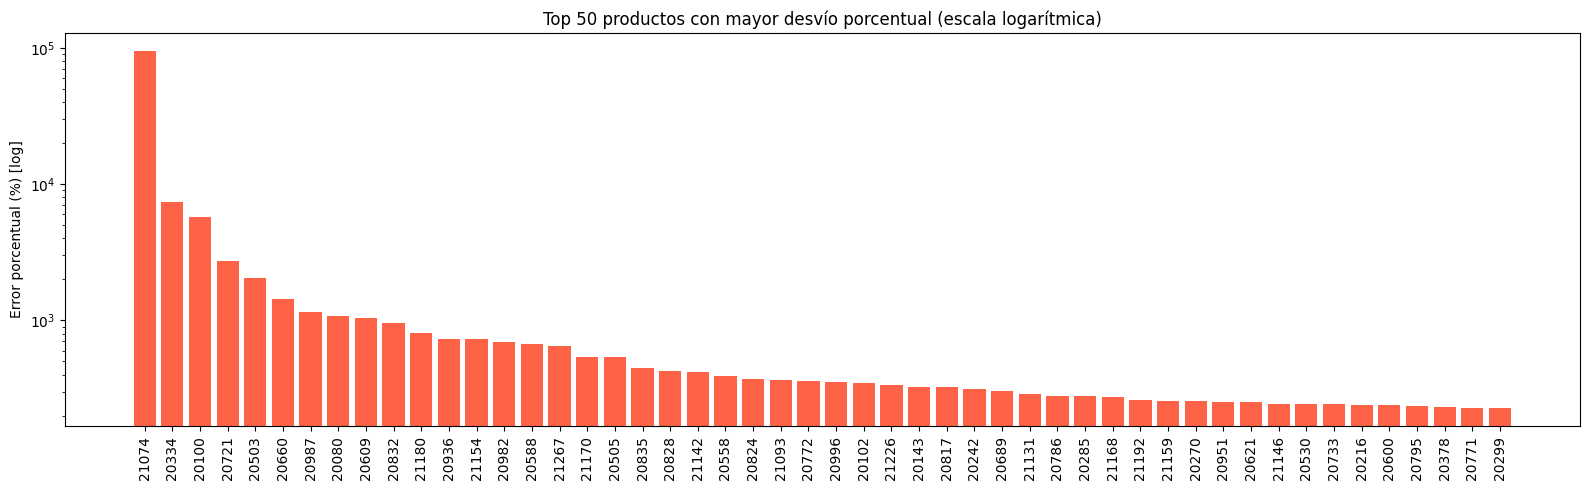

In [10]:

import numpy as np
import matplotlib.pyplot as plt

# Calcular error porcentual
df_error = df_enriquecido.dropna(subset=['tn', 'tn_real']).copy()
df_error = df_error[df_error['tn_real'] != 0]
df_error['error_pct'] = np.abs(df_error['tn'] - df_error['tn_real']) / df_error['tn_real'] * 100

# Ordenar y graficar
df_sorted = df_error.sort_values('error_pct', ascending=False).head(50)

# Graficar en escala logarítmica
plt.figure(figsize=(16, 5))
plt.bar(df_sorted['product_id'].astype(str), df_sorted['error_pct'], color='tomato')
plt.yscale('log')  # escala logarítmica
plt.xticks(rotation=90)
plt.ylabel('Error porcentual (%) [log]')
plt.title('Top 50 productos con mayor desvío porcentual (escala logarítmica)')
plt.tight_layout()
plt.show()


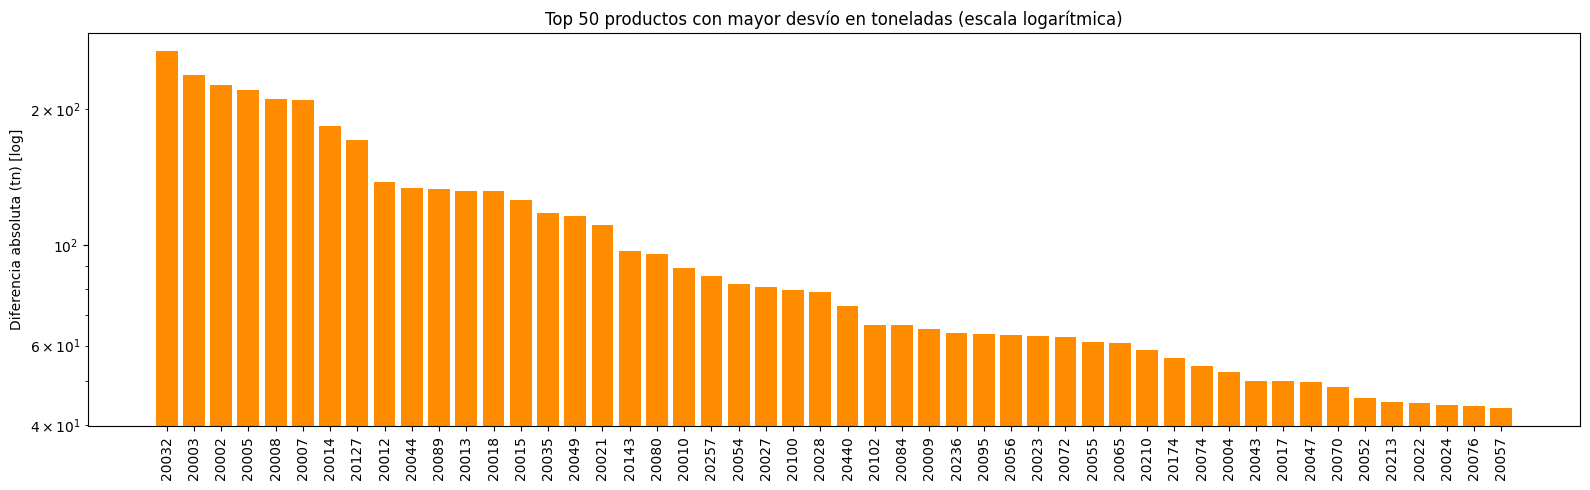

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Calcular diferencia absoluta en tn
df_error = df_enriquecido.dropna(subset=['tn', 'tn_real']).copy()
df_error = df_error[df_error['tn_real'] != 0]
df_error['error_tn'] = np.abs(df_error['tn'] - df_error['tn_real'])

# Ordenar y seleccionar top 50 por toneladas
df_sorted = df_error.sort_values('error_tn', ascending=False).head(50)

# Graficar en escala logarítmica
plt.figure(figsize=(16, 5))
plt.bar(df_sorted['product_id'].astype(str), df_sorted['error_tn'], color='darkorange')
plt.yscale('log')  # escala logarítmica
plt.xticks(rotation=90)
plt.ylabel('Diferencia absoluta (tn) [log]')
plt.title('Top 50 productos con mayor desvío en toneladas (escala logarítmica)')
plt.tight_layout()
plt.show()
